In [1]:
import os
import cv2
import keras
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.2


In [2]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [3]:
# modified from
# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = [item for item in os.listdir(dirName) if not item.startswith('.')]
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
            
    allFiles = [each for each in allFiles if each.endswith((".jpg", ".jpeg", ".png"))]           
    return allFiles

In [4]:
train_image_files_path = "/keras2production/fruits/Training/"
train_images = getListOfFiles(train_image_files_path)

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [5]:
inet_model = inception_v3.InceptionV3()

96116736/96112376 [==============================] - 29s 0us/step


In [6]:
def classify_image(image):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # images need to be numpy arrays
    image = image_utils.load_img(image, target_size=(299, 299))
    image = image_utils.img_to_array(image)

    # expand the dimensions
    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    image = preprocess_input(image)
        
    preds = inet_model.predict(image)
    res = decode_predictions(preds, top=3)
    
    for (i, (imagenetID, label, prob)) in enumerate(res[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

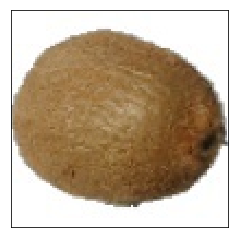

1. French_loaf: 26.34%
2. strawberry: 11.63%
3. brain_coral: 7.47%


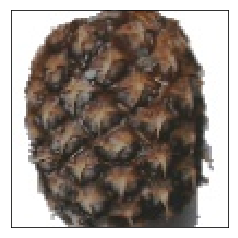

1. pineapple: 95.54%
2. maraca: 0.16%
3. custard_apple: 0.11%


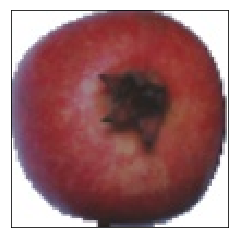

1. pomegranate: 19.22%
2. Granny_Smith: 9.34%
3. earthstar: 7.85%


In [7]:
for i in [10, 1010, 2010]:
    classify_image(train_images[i])

In [8]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_utils.load_img(img_path, target_size=(299, 299))
        x = image_utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [9]:
images = transform_img_fn([os.path.join('test_images', 'Banana', 'Banana_wiki.jpg')])

('n07753592', 'banana', 0.99999297)
('n07747607', 'orange', 1.1464743e-06)
('n07716906', 'spaghetti_squash', 2.1448774e-07)
('n04548280', 'wall_clock', 1.8645702e-07)
('n01728572', 'thunder_snake', 9.827431e-08)


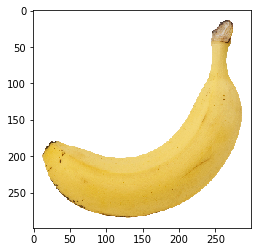

In [10]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [11]:
df = pd.DataFrame(preds)
df.idxmax(axis=1)

0    954
dtype: int64

In [12]:
explainer = lime_image.LimeImageExplainer()

In [13]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels# Hide  
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 17min 28s, sys: 1min 55s, total: 19min 23s
Wall time: 5min 11s


In [14]:
type(explanation)

lime.lime_image.ImageExplanation

In [15]:
from skimage.segmentation import mark_boundaries

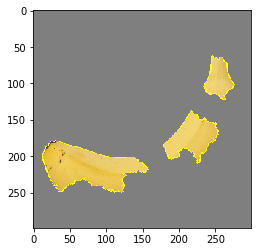

In [16]:
temp, mask = explanation.get_image_and_mask(954, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

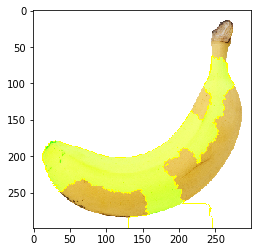

In [17]:
temp, mask  =  explanation.get_image_and_mask(954, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))